# Churn Analysis at a Telecom Provider
This outputs a machine learning model that predicts the probability that an existing client will churn.

Objective:
Using a csv that contains information about customers, including whether they churned, craft a strategy to help her decrease churn.

> Who: Consulting client from a telecom provider.

> What: Tool to predict churn

> Why: Get actionable insight on how to decrease revenue lost to churn

Created by Edwin Campos on 2021 Nov.28.
Last modification on 2021 Nov.27 by ecampos.phd@gmail.com

In [1]:
# Dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#import pickle

In [2]:
# Global Variables
INPUT_PATH = './'
INPUT_FILE = 'telecom_users.csv'
TARGET = 'Churn'   # Column in dataframe with target values, Leave:Yes, Stay:No

## Ingest Input dataset

In [3]:
df_all=pd.read_csv(INPUT_PATH+INPUT_FILE, low_memory=False, na_values=' ')
print(df_all.shape)
print(df_all.columns)

(5986, 22)
Index(['Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')


## Eliminate Columns based on ethical reasons

In [4]:
df_all.drop(['gender', 'SeniorCitizen'], axis=1, inplace=True)
df_all.head()

,Unnamed: 0,customerID,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,6344,9286-DOJGF,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,432,2181-UAESM,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


## Eliminate Columns in which the client has no option to change outcome
The goal here is to simplify the model

In [5]:
df_all.drop(['Partner', 'Dependents'], axis=1, inplace=True)
df_all.head()

,Unnamed: 0,customerID,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,6344,9286-DOJGF,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,432,2181-UAESM,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


### Are there duplicated rows?

In [6]:
# Eliminate duplicated rows (keeping only one per duplicate group)
duplicate_rows_count = df_all.duplicated().sum()
if duplicate_rows_count != 0:
    print( "We need to eliminate", duplicate_rows_count , "duplicated rows")
    df_all.drop_duplicates(inplace=True)
    print( "After deleting these rows, there are now", df_all.duplicated().sum(), "duplicated rows") 
else:
    print( "Looks Good! There are", duplicate_rows_count , "duplicated rows")


Looks Good! There are 0 duplicated rows


## Eliminate other, non-informative columns

In [7]:
df_all.drop(['Unnamed: 0', 'customerID'], axis=1, inplace=True)
df_all.head()

,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


## Is the target data useful for a classification model?

In [8]:
df_all['Churn']

0        No
1        No
2       Yes
3        No
4        No
5        No
6        No
7        No
8        No
9        No
10       No
11      Yes
12       No
13       No
14       No
15       No
16       No
17       No
18      Yes
19      Yes
20       No
21       No
22       No
23      Yes
24      Yes
25       No
26      Yes
27       No
28      Yes
29       No
       ... 
5956     No
5957    Yes
5958     No
5959     No
5960     No
5961     No
5962    Yes
5963     No
5964     No
5965     No
5966     No
5967     No
5968     No
5969     No
5970     No
5971     No
5972     No
5973    Yes
5974     No
5975     No
5976    Yes
5977     No
5978     No
5979     No
5980    Yes
5981    Yes
5982     No
5983     No
5984    Yes
5985     No
Name: Churn, Length: 5986, dtype: object

In [9]:
# Rename Yes and No with True and False
df_all = df_all.replace({'Churn': {'Yes': True, 'No': False}},
                        #inplace=True
                       )
df_all['Churn']

0       False
1       False
2        True
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11       True
12      False
13      False
14      False
15      False
16      False
17      False
18       True
19       True
20      False
21      False
22      False
23       True
24       True
25      False
26       True
27      False
28       True
29      False
        ...  
5956    False
5957     True
5958    False
5959    False
5960    False
5961    False
5962     True
5963    False
5964    False
5965    False
5966    False
5967    False
5968    False
5969    False
5970    False
5971    False
5972    False
5973     True
5974    False
5975    False
5976     True
5977    False
5978    False
5979    False
5980     True
5981     True
5982    False
5983    False
5984     True
5985    False
Name: Churn, Length: 5986, dtype: bool

In [10]:
# Show how unbalanced is the Target data
counts = df_all['Churn'].value_counts()
perc = df_all['Churn'].value_counts(normalize=True).mul(100).round(1)
pd.DataFrame({'counts': counts, 'percents': perc})

,counts,percents
False,4399,73.5
True,1587,26.5


## Feature Engineering

In [11]:
# Do we have columns with too many missing values?
print("% of missing observations:")
print(df_all.isnull().mean()*100)

% of missing observations:
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.167056
Churn               0.000000
dtype: float64


There is only one column with missing values, at 17%

This would problematic later, because scikit-learn estimators which assume that all values in an array are numerical.

To address this issue, we can either remove the column or **impute** the missing values.

In [12]:
# Impute the missing values with the median of the column
df_all['TotalCharges'].fillna(df_all['TotalCharges'].median(), inplace=True)

In [13]:
print("% of missing observations:")
print(df_all.isnull().mean()*100)

% of missing observations:
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


Much better! Now there are no columns with missing values.

### Handle Non-Numeric values

In [14]:
df_all.dtypes

tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                  bool
dtype: object

In [15]:
non_numeric_columns = list(df_all.select_dtypes(include=['object']).columns)
#non_numeric_columns.remove(TARGET) 
non_numeric_columns

['PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [16]:
# Remove special characters from PaymentMethod column
for col in non_numeric_columns:
    new_col = col+'_clean'
    df_all[new_col] = df_all[col].str.replace('\W', '')
    #print(df_all[[col, new_col]])
    df_all.drop([col], axis=1, inplace=True)

In [17]:
df_all.dtypes

tenure                      int64
MonthlyCharges            float64
TotalCharges              float64
Churn                        bool
PhoneService_clean         object
MultipleLines_clean        object
InternetService_clean      object
OnlineSecurity_clean       object
OnlineBackup_clean         object
DeviceProtection_clean     object
TechSupport_clean          object
StreamingTV_clean          object
StreamingMovies_clean      object
Contract_clean             object
PaperlessBilling_clean     object
PaymentMethod_clean        object
dtype: object

In [18]:
# Apply One-Hot-Encoding 
onehotencoding_columns = list(df_all.select_dtypes(include=['object']).columns)
#onehotencoding_columns.remove(TARGET)
for col in onehotencoding_columns:
    df_dummies = pd.get_dummies(df_all[col], prefix = col)
    df_all = pd.concat([df_all, df_dummies], axis=1)

In [19]:
# Remove the columns than needed One-Hot-Encoding
df_all.drop(onehotencoding_columns, axis=1, inplace=True)
df_all.head()

,tenure,MonthlyCharges,TotalCharges,Churn,PhoneService_clean_No,PhoneService_clean_Yes,MultipleLines_clean_No,MultipleLines_clean_Nophoneservice,MultipleLines_clean_Yes,InternetService_clean_DSL,...,StreamingMovies_clean_Yes,Contract_clean_Monthtomonth,Contract_clean_Oneyear,Contract_clean_Twoyear,PaperlessBilling_clean_No,PaperlessBilling_clean_Yes,PaymentMethod_clean_Banktransferautomatic,PaymentMethod_clean_Creditcardautomatic,PaymentMethod_clean_Electroniccheck,PaymentMethod_clean_Mailedcheck
0,72,24.10,1734.65,False,0,1,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
1,44,88.15,3973.20,False,0,1,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,38,74.95,2869.85,True,0,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
3,4,55.90,238.50,False,0,1,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
4,2,53.45,119.50,False,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0


In [20]:
df_all.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'PhoneService_clean_No', 'PhoneService_clean_Yes',
       'MultipleLines_clean_No', 'MultipleLines_clean_Nophoneservice',
       'MultipleLines_clean_Yes', 'InternetService_clean_DSL',
       'InternetService_clean_Fiberoptic', 'InternetService_clean_No',
       'OnlineSecurity_clean_No', 'OnlineSecurity_clean_Nointernetservice',
       'OnlineSecurity_clean_Yes', 'OnlineBackup_clean_No',
       'OnlineBackup_clean_Nointernetservice', 'OnlineBackup_clean_Yes',
       'DeviceProtection_clean_No', 'DeviceProtection_clean_Nointernetservice',
       'DeviceProtection_clean_Yes', 'TechSupport_clean_No',
       'TechSupport_clean_Nointernetservice', 'TechSupport_clean_Yes',
       'StreamingTV_clean_No', 'StreamingTV_clean_Nointernetservice',
       'StreamingTV_clean_Yes', 'StreamingMovies_clean_No',
       'StreamingMovies_clean_Nointernetservice', 'StreamingMovies_clean_Yes',
       'Contract_clean_Monthtomonth', 'Contract

In [21]:
df_all.shape

(5986, 39)

## Compute the Covariance Matrix

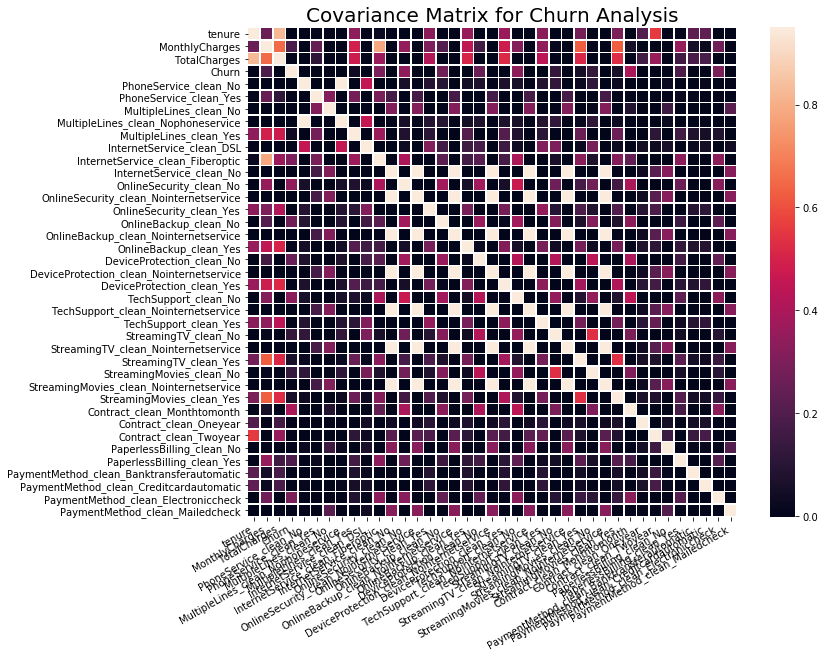

In [22]:
df_all_correl_matrix = df_all.corr()
fig = plt.figure(figsize = (12,9))
heatmap = sns.heatmap(df_all_correl_matrix, cbar=True, 
                      linewidths=.5, square=True,
                      annot=False,
                      vmin=-0.001, vmax=0.95
                      #vmin=-0.40, vmax=-0.39
                     )
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30, horizontalalignment='right') 
plt.title("Covariance Matrix for Churn Analysis", fontsize = 20) # title with fontsize 20
plt.savefig('AnalyzeChurn_covariance.png', dpi=300, bbox_inches='tight') #  set bbox_inches='tight' so the axis labels in the plot are NOT cut off in the saved image
plt.show()

## Identify Redundant Features

In [23]:
def identify_collinear(df, correlation_threshold):
    """
    Finds collinear features based on the correlation coefficient between features. 
    For each pair of features with a correlation coefficient greather than `correlation_threshold`,
    only one of the pair is identified for removal. 
    Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

    Parameters
    --------
    df : Pandas dataframe of model features, with variable names in its columns, and one set of variables per row
    correlation_threshold : float between 0 and 1
        Value of the Pearson correlation cofficient for identifying correlation features
    """
    # Dictionary to hold removal operations
    ops = {}
    
    # Dataset and column names
    base_features = list(df.columns)
        
    # Calculate the correlations between every column
    corr_matrix = df.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    # Dataframe to hold correlated pairs
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop to record pairs of correlated features
    for column in to_drop:

        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})

        # Add to dataframe
        record_collinear = record_collinear.append(temp_df, ignore_index = True)

    #self.record_collinear = record_collinear
    ops['collinear'] = to_drop

    print('%d feature(s) with a correlation magnitude greater than %0.2f.\n' % (len(ops['collinear']), correlation_threshold))

    return record_collinear

In [24]:
full_colinearity_df = identify_collinear(df_all, correlation_threshold=0.95)
full_colinearity_df

9 feature(s) with a correlation magnitude greater than 0.95.



,drop_feature,corr_feature,corr_value
0,PhoneService_clean_Yes,PhoneService_clean_No,-1.0
1,MultipleLines_clean_Nophoneservice,PhoneService_clean_No,1.0
2,MultipleLines_clean_Nophoneservice,PhoneService_clean_Yes,-1.0
3,OnlineSecurity_clean_Nointernetservice,InternetService_clean_No,1.0
4,OnlineBackup_clean_Nointernetservice,InternetService_clean_No,1.0
5,OnlineBackup_clean_Nointernetservice,OnlineSecurity_clean_Nointernetservice,1.0
6,DeviceProtection_clean_Nointernetservice,InternetService_clean_No,1.0
7,DeviceProtection_clean_Nointernetservice,OnlineSecurity_clean_Nointernetservice,1.0
8,DeviceProtection_clean_Nointernetservice,OnlineBackup_clean_Nointernetservice,1.0
9,TechSupport_clean_Nointernetservice,InternetService_clean_No,1.0


> Consider removing columns=drop_features where cor_value=1.0 .

    # Remove the features and return the data
    features_to_drop = list(full_colinearity_df['drop_feature'])
    trim_df = df_all.drop(columns = features_to_drop)
    trim_df.describe()

## Identify features and target columns

In [25]:
feature_columns =[x for x in df_all.columns if x != TARGET]
feature_columns

['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'PhoneService_clean_No',
 'PhoneService_clean_Yes',
 'MultipleLines_clean_No',
 'MultipleLines_clean_Nophoneservice',
 'MultipleLines_clean_Yes',
 'InternetService_clean_DSL',
 'InternetService_clean_Fiberoptic',
 'InternetService_clean_No',
 'OnlineSecurity_clean_No',
 'OnlineSecurity_clean_Nointernetservice',
 'OnlineSecurity_clean_Yes',
 'OnlineBackup_clean_No',
 'OnlineBackup_clean_Nointernetservice',
 'OnlineBackup_clean_Yes',
 'DeviceProtection_clean_No',
 'DeviceProtection_clean_Nointernetservice',
 'DeviceProtection_clean_Yes',
 'TechSupport_clean_No',
 'TechSupport_clean_Nointernetservice',
 'TechSupport_clean_Yes',
 'StreamingTV_clean_No',
 'StreamingTV_clean_Nointernetservice',
 'StreamingTV_clean_Yes',
 'StreamingMovies_clean_No',
 'StreamingMovies_clean_Nointernetservice',
 'StreamingMovies_clean_Yes',
 'Contract_clean_Monthtomonth',
 'Contract_clean_Oneyear',
 'Contract_clean_Twoyear',
 'PaperlessBilling_clean_No',
 'Paperle

In [26]:
# Now create an X variable (containing the features) and an y variable (containing only the target variable)
X = df_all[feature_columns]
y = df_all[TARGET]

In [27]:
X.head()

,tenure,MonthlyCharges,TotalCharges,PhoneService_clean_No,PhoneService_clean_Yes,MultipleLines_clean_No,MultipleLines_clean_Nophoneservice,MultipleLines_clean_Yes,InternetService_clean_DSL,InternetService_clean_Fiberoptic,...,StreamingMovies_clean_Yes,Contract_clean_Monthtomonth,Contract_clean_Oneyear,Contract_clean_Twoyear,PaperlessBilling_clean_No,PaperlessBilling_clean_Yes,PaymentMethod_clean_Banktransferautomatic,PaymentMethod_clean_Creditcardautomatic,PaymentMethod_clean_Electroniccheck,PaymentMethod_clean_Mailedcheck
0,72,24.10,1734.65,0,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
1,44,88.15,3973.20,0,1,1,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
2,38,74.95,2869.85,0,1,0,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
3,4,55.90,238.50,0,1,1,0,0,1,0,...,1,1,0,0,0,1,0,0,1,0
4,2,53.45,119.50,0,1,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0


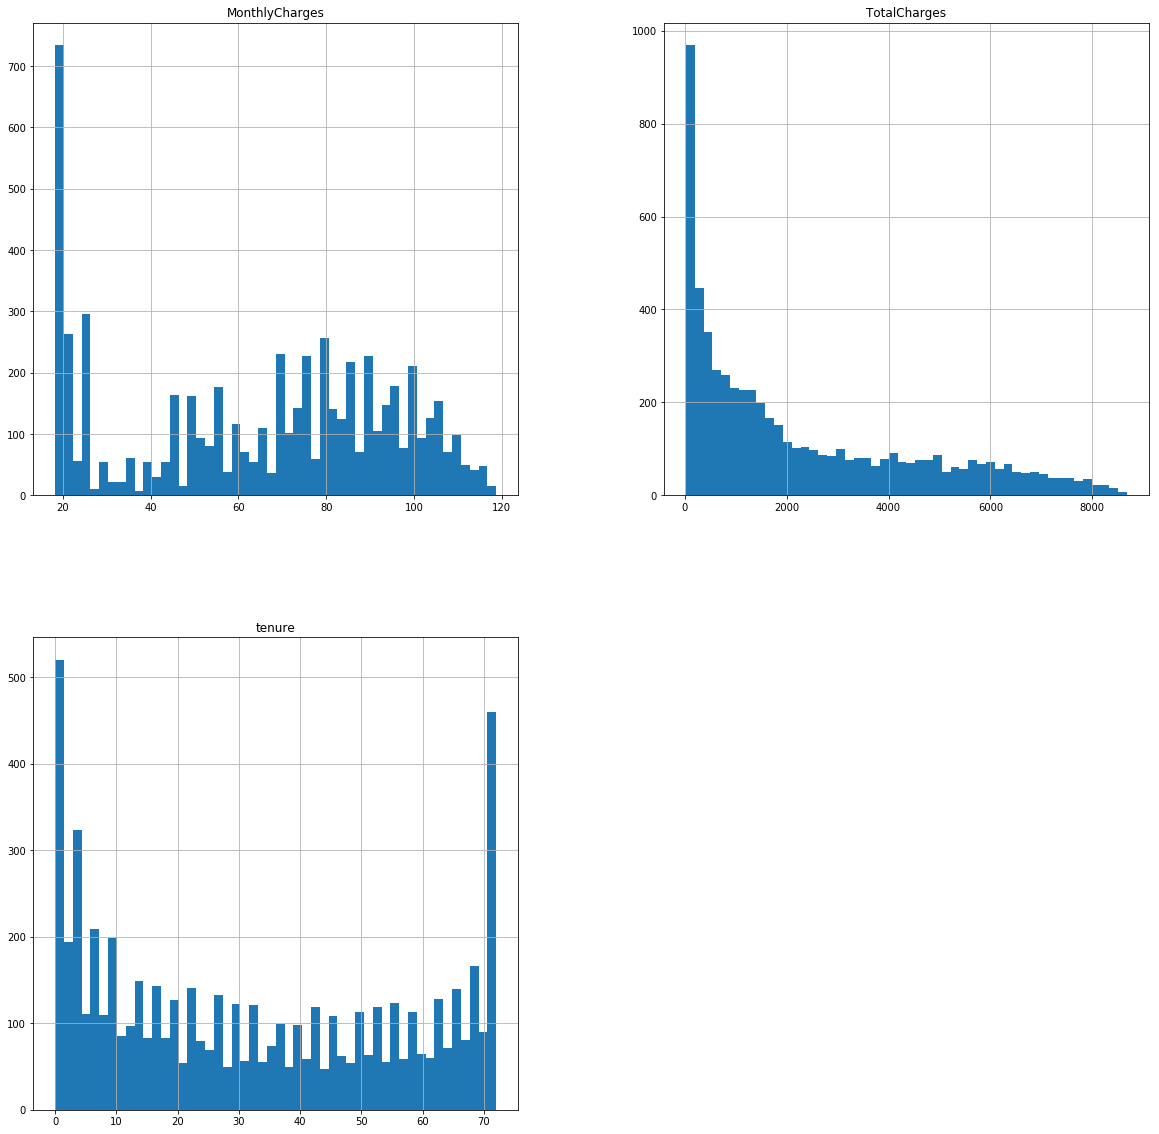

In [28]:
# Plot histograms of each parameter: limit to 4 subplots instead of the '29'
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
#for col in numeric_cols:
X[numeric_cols].hist(bins=50, figsize = (20, 20))
plt.show()

## Split data into training and test (verification)

In [29]:
#Split the data set using 'train_test_split' function
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [30]:
y_train.head()

3707    False
221     False
1260    False
4591    False
3597     True
Name: Churn, dtype: bool

In [31]:
# Show how unbalanced is the Target data
print('BASELINE: Entire Dataset')
counts = df_all['Churn'].value_counts()
perc = df_all['Churn'].value_counts(normalize=True).mul(100).round(1)
pd.DataFrame({'counts': counts, 'percents': perc})

BASELINE: Entire Dataset


,counts,percents
False,4399,73.5
True,1587,26.5


> A predictive model should be better than this baseline: The Majority Class (No Churn, with 73.5% Accurracy)

In [32]:
print('Training Set')
counts = y_train.value_counts()
perc = y_train.value_counts(normalize=True).mul(100).round(1)
pd.DataFrame({'counts': counts, 'percents': perc})

Training Set


,counts,percents
False,3540,73.9
True,1248,26.1


A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset.

In [33]:
weights = {0:26.0, 1:74.0}  # The opposite of the Target Distribution in the training percents

In [34]:
print('Test Set')
counts = y_test.value_counts()
perc = y_test.value_counts(normalize=True).mul(100).round(1)
pd.DataFrame({'counts': counts, 'percents': perc})

Test Set


,counts,percents
False,859,71.7
True,339,28.3


> The Training/Test split did not **significantly** change the unbalanced distribution of the Target

## Train a Logistic Regression Classification Model

In [35]:
# Instantiate the model to an empty object
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight=weights)

# Train the model using 'fit' method on the train dataset
model.fit(X_train, y_train)

/Applications/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={0: 26.0, 1: 74.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [36]:
y_pred_train = model.predict(X_train)

In [37]:
print('TRAINING SET:')
print('Accuracy Score : ' + str(accuracy_score(y_train,y_pred_train)))
print('Precision Score : ' + str(precision_score(y_train,y_pred_train)))
print('Recall Score : ' + str(recall_score(y_train,y_pred_train)))
print('F1 Score : ' + str(f1_score(y_train,y_pred_train)))


TRAINING SET:
Accuracy Score : 0.7472848788638262
Precision Score : 0.509683995922528
Recall Score : 0.8012820512820513
F1 Score : 0.6230529595015576


    PREVIOUS TRAINING SET (with class_weight=Default=None):
    Accuracy Score : 0.8034670008354219   [Hight:Better]
    Precision Score : 0.6488845780795345  [Hight:Better]
    Recall Score : 0.5360576923076923     [Hight:Better] 
    F1 Score : 0.5870996050899517         [1:Perfect, 0:Failure]

## Verify the Supervised Machine-Learning Classification Model

In [38]:
# Verify the model using 'predict' method on the test dataset
y_pred = model.predict(X_test)

In [39]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix

#labels = [0, 1]  # ‘Class’ is the target variable, 1 in case of fraud and 0 otherwise.
conf_matrx = confusion_matrix(y_test, y_pred)
print(conf_matrx)

fp = conf_matrx[0,1]
fn = conf_matrx[1,0]
tp = conf_matrx[1,1]
tn = conf_matrx[0,0]
print(tn,fp,fn,tp)

true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, y_pred).ravel()
print(true_negatives, false_positives, false_negatives, true_positives)

[[628 231]
 [ 74 265]]
628 231 74 265
628 231 74 265


In [40]:
# Print the classification report 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.73      0.80       859
        True       0.53      0.78      0.63       339

   micro avg       0.75      0.75      0.75      1198
   macro avg       0.71      0.76      0.72      1198
weighted avg       0.79      0.75      0.76      1198



In [41]:
accuracy = (tp + tn) / (tp+fp+tn+fn)
print('accuracy =',accuracy)

accuracy = 0.7454090150250418


> Which is already better than the baseline: The Majority Class (No Churn, with 73.5% Accurracy)

However, the TEST SET with class_weight=Default ==> accuracy = 0.7904841402337228

In [42]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix', 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,int(round(cm[i,j])),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[2578  962]
 [ 248 1000]]
[[53.84294069 20.09189641]
 [ 5.17961571 20.8855472 ]]


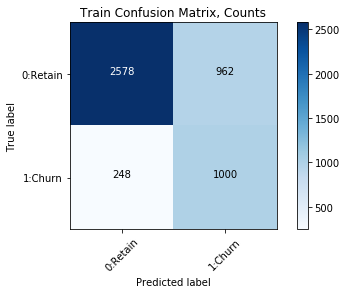

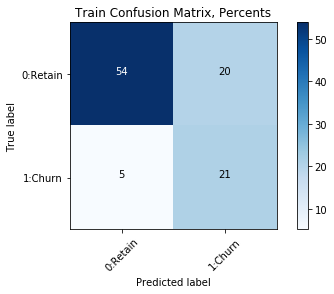

In [43]:
# Plot Confusion Matrix in counts
plt.figure() 
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(conf_matrix_train, classes=['0:Retain','1:Churn'], 
                      title="Train Confusion Matrix, Counts")
plt.figure()
#plt.savefig('AnalyzeChurn_conf_matrix_counts_train.png')

# Plot Confusion Matrix in percents
conf_matrix_train_percents = 100.0 * conf_matrix_train /float(len(y_train))
plot_confusion_matrix(conf_matrix_train_percents, classes=['0:Retain','1:Churn'],
                      title="Train Confusion Matrix, Percents")
plt.show
plt.savefig('AnalyzeChurn_conf_matrix_prcnts_train.png')

[[628 231]
 [ 74 265]]
[[52.42070117 19.28213689]
 [ 6.1769616  22.12020033]]


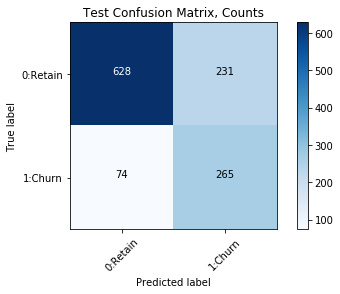

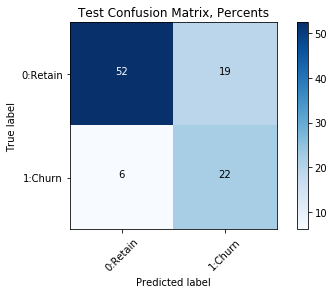

In [44]:
# Plot Confusion Matrix in counts
plt.figure() 
plot_confusion_matrix(conf_matrx, classes=['0:Retain','1:Churn'], 
                      title="Test Confusion Matrix, Counts")
plt.figure()
#plt.show
#plt.savefig('AnalyzeChurn_conf_matrix_counts_test.png')

# Plot Confusion Matrix in percents
conf_matrix_test_percents = 100.0 * conf_matrx /float(len(y_test))
plot_confusion_matrix(conf_matrix_test_percents, classes=['0:Retain','1:Churn'],
                      title="Test Confusion Matrix, Percents")
plt.show
plt.savefig('AnalyzeChurn_conf_matrix_prcnts_test.png')

Confusion Matrix with Weights on class percents:

    [[628 231]
     [ 74 265]]
    [[52.42070117 19.28213689]
     [ 6.1769616  22.12020033]]

Confusion Matrix with NO Weights on class percents:

    [[780  79]
     [172 167]]
    [[65.10851419  6.59432387]
     [14.3572621  13.93989983]]
 
> Very Similar Confusion Matrices for Train and Test sets 

> ==> Overfitting is unlikely

## Feature Importance

In [45]:
plt.style.use('ggplot')

In [46]:
coef_dict_baseline = {}
for coef, feat in zip(model.coef_[0], X_train.columns):
    coef_dict_baseline[feat] = coef
print(coef_dict_baseline)

{'tenure': -0.0497223242283264, 'MonthlyCharges': 0.0063665350960620945, 'TotalCharges': 0.0002627576266959164, 'PhoneService_clean_No': 0.11401353586158107, 'PhoneService_clean_Yes': -0.18481278555426567, 'MultipleLines_clean_No': -0.19445349467773373, 'MultipleLines_clean_Nophoneservice': 0.11401353586158107, 'MultipleLines_clean_Yes': 0.009640709123466202, 'InternetService_clean_DSL': -0.2715766408150481, 'InternetService_clean_Fiberoptic': 0.2693084551797183, 'InternetService_clean_No': -0.06853106405736055, 'OnlineSecurity_clean_No': 0.27181167253909644, 'OnlineSecurity_clean_Nointernetservice': -0.06853106405736055, 'OnlineSecurity_clean_Yes': -0.2740798581744293, 'OnlineBackup_clean_No': 0.0931237609922661, 'OnlineBackup_clean_Nointernetservice': -0.06853106405736055, 'OnlineBackup_clean_Yes': -0.09539194662759494, 'DeviceProtection_clean_No': 0.09109222044889008, 'DeviceProtection_clean_Nointernetservice': -0.06853106405736055, 'DeviceProtection_clean_Yes': -0.09336040608421899

In [47]:
list(coef_dict_baseline.values())

[-0.0497223242283264,
 0.0063665350960620945,
 0.0002627576266959164,
 0.11401353586158107,
 -0.18481278555426567,
 -0.19445349467773373,
 0.11401353586158107,
 0.009640709123466202,
 -0.2715766408150481,
 0.2693084551797183,
 -0.06853106405736055,
 0.27181167253909644,
 -0.06853106405736055,
 -0.2740798581744293,
 0.0931237609922661,
 -0.06853106405736055,
 -0.09539194662759494,
 0.09109222044889008,
 -0.06853106405736055,
 -0.09336040608421899,
 0.18589573930227168,
 -0.06853106405736055,
 -0.1881639249376245,
 -0.08997426722499557,
 -0.06853106405736055,
 0.08770608158966402,
 -0.10063850622816133,
 -0.06853106405736055,
 0.0983703205928266,
 0.6995884516707078,
 -0.028052206872054647,
 -0.7423354944913362,
 -0.20495006075402256,
 0.13415081106134402,
 -0.18526751377901035,
 -0.043454660064043686,
 0.28937407153774647,
 -0.1314511473873968]

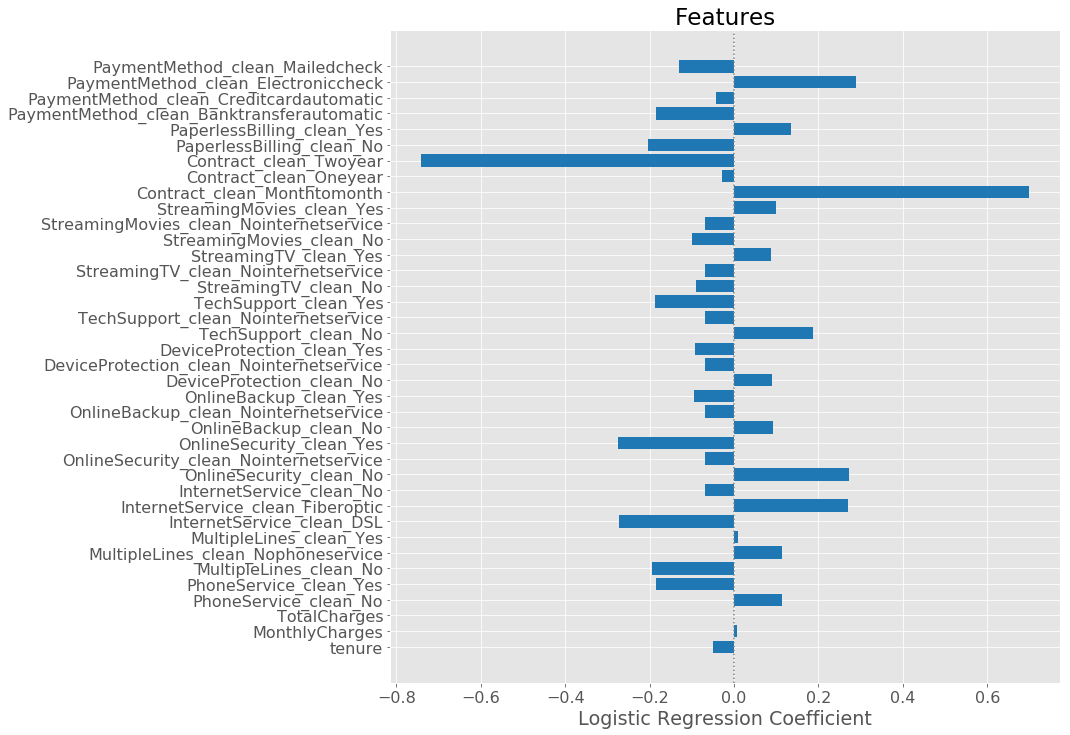

In [48]:
# Horizontal Bars
plt.rc('font', size=16) # For title and axis labels

plt.figure(figsize = (12,12))
#plt.bar(coef_dict_baseline.keys(), coef_dict_baseline.values())

y_pos = np.arange( len( coef_dict_baseline.keys() ) )
plt.barh(y_pos, list(coef_dict_baseline.values()), color='tab:blue')
plt.yticks(y_pos, coef_dict_baseline.keys())
plt.axvline(x=0, color='gray', linestyle=':')
#ax.set_yticks(y_pos)
#ax.set_yticklabels(people)
#ax.invert_yaxis()  # labels read top-to-bottom

#plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Logistic Regression Coefficient')
plt.title('Features')
plt.savefig('AnalyzeChurn_coefficients.png', # This generates an error when lead_time_string has special characters such as '/'
            dpi=300, 
            bbox_inches='tight',  #  set bbox_inches='tight' so the axis labels in the plot are NOT cut off in the saved image
           ) 
plt.show()

Recall this is a classification problem with classes Churn=0 and Churn=1. 
Notice that the coefficients are both positive and negative. 
> The positive coefficients indicate a feature that predicts class Churn=1=True, whereas the **negative coefficients** indicate a feature that predicts class **Churn=0=False**.

### To reduce Churn, try to offer a Special so that clients sign for a 2-year contract, Internet Service DSL, and/or Online Security.

## Save the model for later deployment

In [50]:
# Save the model as a Pickle file
from sklearn.externals import joblib
joblib.dump(value=model, filename='AnalyzeChurn_model.pkl')

['AnalyzeChurn_model.pkl']